### Trains model

In [1]:
import os 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efn
import tensorflow as tf
import keras

CFG_NAME = "eb0" # name of the configuration
ROOT_DIR = os.path.abspath("../")


DATASET_NAME = "mit-bih-ad-images" 
TRAIN_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"train")
VALID_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"val")
TEST_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"test")


if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
# Make log path to store all results
LOG_PATH = os.path.join(ROOT_DIR, "logs", CFG_NAME)
    
# Make new directory
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
       
# Open log file
log_file = open("{}/{}_log.out".format(LOG_PATH, CFG_NAME), 'w')
#sys.stdout = log_file

Using TensorFlow backend.


### Load dataset

In [2]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


def processing_func(img):
    # do sth
    return img


# Size of image
image_size = (288, 432)
batch_size = 8

# Use augmentations
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=None)


# No augmentations
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size
)

validation_generator = validation_datagen.flow_from_directory(
    VALID_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False
)

Found 60560 images belonging to 2 classes.
Found 23821 images belonging to 2 classes.
Found 24718 images belonging to 2 classes.


In [3]:
x, y = next(iter(test_generator))
x.shape, y.shape

((8, 288, 432, 3), (8, 2))

[1. 0.]


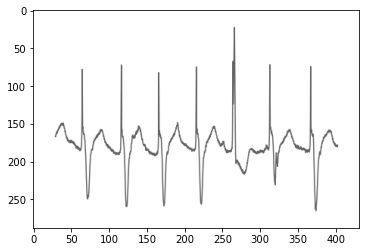

In [4]:
print(y[0])
plt.imshow(x[0])

### Define model

In [5]:
from keras.layers import Input, Conv2D, Dense
from keras.models import Model
from keras.optimizers import Adam

def classification_network():
    
    # Pre-trained model
    base_model = efn.EfficientNetB3(weights='imagenet',include_top=False,pooling='avg',input_shape=(288, 432, 3))
    
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    # Unfreeze layers
    for layer in base_model.layers:
        layer.trainable=True
    
    # Build model
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer
    optim = Adam(lr=1e-5)

    # Loss function
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model

model = None
model = classification_network()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 288, 432, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 144, 216, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 144, 216, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 144, 216, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

### Set callbacks

In [6]:
# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(LOG_PATH, CFG_NAME), verbose=1, monitor='val_accuracy', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, verbose=1, patience=5, mode='max'),
    keras.callbacks.CSVLogger('{}/training.csv'.format(LOG_PATH)),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=8, restore_best_weights=True)
]

### Class weights for data imbalance

In [7]:
#Define class weights for imbalacned data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
print(class_weights)

[1.51749023 0.74570261]


/home/hasib/anaconda3/envs/ecg/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Train model

In [ ]:
start_time = time.time()

history = model.fit_generator(train_generator, 
                    epochs=500, validation_data = validation_generator, 
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks=callbacks, shuffle=True)

end_time = time.time()
print("--- Time taken to train : %s min ---" % ((end_time - start_time)//60))

Epoch 1/500
7570/7570 [==============================] - 2657s 351ms/step - loss: 0.2662 - accuracy: 0.8904 - val_loss: 0.3407 - val_accuracy: 0.7537

Epoch 00001: val_accuracy improved from -inf to 0.75366, saving model to /home/hasib/hasib/ecg-heart/logs/eb0/eb0.h5
Epoch 2/500
7570/7570 [==============================] - 2644s 349ms/step - loss: 0.1481 - accuracy: 0.9404 - val_loss: 1.1703 - val_accuracy: 0.6702

Epoch 00002: val_accuracy did not improve from 0.75366
Epoch 3/500
7570/7570 [==============================] - 2645s 349ms/step - loss: 0.1180 - accuracy: 0.9492 - val_loss: 1.2938 - val_accuracy: 0.7853

Epoch 00003: val_accuracy improved from 0.75366 to 0.78527, saving model to /home/hasib/hasib/ecg-heart/logs/eb0/eb0.h5
Epoch 4/500
1235/7570 [===>..........................] - ETA: 34:41 - loss: 0.1122 - accuracy: 0.9528

In [ ]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()

plot_loss_accu(history)
print("Done training and logging!")

### Load best weights and test model performance

In [ ]:
from keras.models import load_model

model = None
model = load_model("{}/{}.h5".format(LOG_PATH, CFG_NAME), compile = False)

In [ ]:
# # validation data
# VALID_DATA_PATH = os.path.join(ROOT_DIR, "datasets/numpy/")
# x_test = np.load("{}/sportornot_validation_set_images.npy".format(VALID_DATA_PATH))
# y_test = np.load("{}/sportornot_validation_set_labels.npy".format(VALID_DATA_PATH))
# # test data
# #x_test = np.load("{}/sportornot_test_set_images.npy".format(VALID_DATA_PATH))
# #y_test = np.load("{}/sportornot_test_set_labels.npy".format(VALID_DATA_PATH))
# print(x_test.shape, y_test.shape)

# # Standardize
# x_test = x_test.astype('float32')
# x_test /= 255

# # Make predictions using trained model
# y_pred = model.predict(x_test, verbose=1)
# print("Predictions: ", y_pred.shape)

# # Convert ground truth to column values
# y_test_flat = np.argmax(y_test, axis=1)
# print("After flattening ground truth: ", y_test_flat.shape)

# # Get labels from predictions
# y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) 
# print("Binarize probability values: ", y_pred_flat.shape)

# assert y_pred_flat.shape == y_test_flat.shape, "Shape mismatch!"

# y_pred = y_pred_flat
# y_test = y_test_flat

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALID_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False
)

# Validation labels
y_test = validation_generator.classes
# Make preds
y_pred = model.predict_generator(validation_generator)
# Get labels from predictions
y_pred = np.array([np.argmax(pred) for pred in y_pred]) 

assert y_test.shape == y_pred.shape, "Shape mismatch!"


from sklearn.metrics import accuracy_score

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy :", acc)


from sklearn.metrics import classification_report

# Classification report
target_names = ['non-sport', 'sport']
print(classification_report(y_test, y_pred, target_names=target_names))

### Test peformance

In [ ]:
# Test labels
y_test = test_generator.classes
# Make preds
y_pred = model.predict_generator(test_generator)
# Get labels from predictions
y_pred = np.array([np.argmax(pred) for pred in y_pred]) 

assert y_test.shape == y_pred.shape, "Shape mismatch!"


from sklearn.metrics import accuracy_score

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy :", acc)


from sklearn.metrics import classification_report

# Classification report
target_names = ['non-sport', 'sport']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# from sklearn.metrics import roc_auc_score
# print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

In [ ]:
# from sklearn.metrics import f1_score
# F1_score = f1_score(y_test, y_pred, average='weighted')
# print("F1 score: ", F1_score)

In [ ]:
print("------------------------------------End of script------------------------------------")